# The Contribution of the Opioid Epidemic on the Falling Life Expectancy in the United States

### Sabrina Pereira

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import linregress

In [2]:
''' 
Data loading and cleaning. Methodology section of the notebook will cover this process in more detail.

'''

nchs = pd.read_csv('nchs.csv', sep=',')
opioid = pd.read_csv('Opioid Related Deaths, 1999-2017.txt', sep='\t')
mortality = pd.read_csv('All Deaths, 1999-2017.txt', sep='\t')

# Extract total deaths
opioid_totals = opioid[(opioid.Notes == 'Total') & (opioid.Year.notna())].reset_index(drop=True)
mortality_totals = mortality[(mortality.Notes == 'Total') & (mortality.Year.notna())].reset_index(drop=True)

# Clean data to only contain rows that have valid years
opioid = opioid[(opioid.Year.notna()) & (opioid['Ten-Year Age Groups Code'] != 'NS') & (opioid.Notes.isna())]
mortality = mortality[(mortality.Year.notna()) & (mortality['Ten-Year Age Groups Code'] != 'NS') & (mortality.Notes.isna())]
opioid['Crude Rate'].replace('Unreliable',0, inplace=True)     # In cases where the Crude Rate is very small it is termed "Unreliable", we will replace it with 0

# Manually adding the nchs data to a data frame with the most recent data 
d = {'Year': [2017, 2016, 2015], 'Race': 3*['All Races'], 'Sex' : 3*['Both Sexes'], 'Average Life Expectancy (Years)':[78.6,78.7, 78.7], 'Age-adjusted Death Rate': [731.9, 728.8, 733.1]}
df = pd.DataFrame(data=d)
nchs = df.append(nchs.drop([0]), ignore_index=True)

# Select NCHS data that aligns with mortality data, describing all people in the US, from 1999-2017, and in year ascending order
everyone = nchs[(nchs.Race == 'All Races') & (nchs.Sex == 'Both Sexes')]
recent = everyone[everyone.Year > 1998][::-1].reset_index(drop=True)

## **Introduction**

In recent years, a downward trend in the Average Life Expectancy in the US has emerged. 

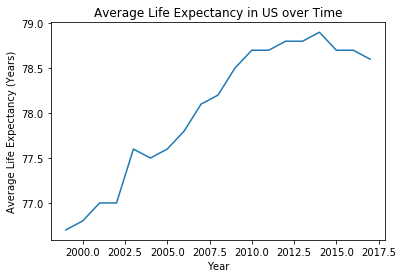

In [3]:
plt.plot(recent.Year, recent['Average Life Expectancy (Years)'])
plt.xlabel('Year')
plt.ylabel('Average Life Expectancy (Years)')
plt.title('Average Life Expectancy in US over Time');

At the same time, the number of deaths by opioid poisoning have risen dramatically. In 1999, there were 6.0 opioid poisoning related deaths for every 100,000 people - by 2017, this had risen to 21.6 deaths per 100,000. What is known as the "Opioid Epidemic" or "Opioid Crisis" was declared a Public Health Emergency by the Trump Administration's Health and Human Services in 2017.

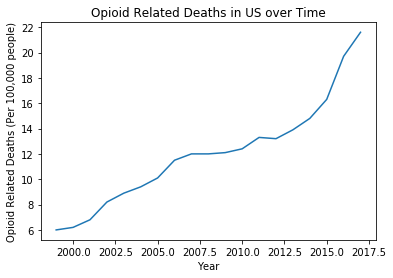

In [4]:
plt.plot(opioid_totals.Year, opioid_totals['Crude Rate'].astype('float64'))
plt.xlabel('Year')
plt.ylabel('Opioid Related Deaths (Per 100,000 people)')
plt.title('Opioid Related Deaths in US over Time');

Around 2015, at the same time we start noticing that the number of opioid overdose related deaths start dramatically increasing, the Average Life Expectancy starts to drop.

This prompted me to ask,

_**What is the effect of the increased opioid-related deaths on the Average Life Expectancy in the US?**_

## **Methodology**

To answer this question, I will be attempting to predict what the Average Life Expectancy (ALE) in the US for various years would look like if there were no deaths related to opioid overdoses, and compare how much the actual ALEs differ from this theoretical, Zero-Opioid Scenario ALE.

### Data Sources

I will be using the Centers for Disease Control and Prevention's (CDC) National Center for Health Statistics (NCHS) data for Death rates and life expectancy at birth for the US (Available at https://data.cdc.gov/NCHS/NCHS-Death-rates-and-life-expectancy-at-birth/w9j2-ggv5 ). All further mentions of life expectancies or ALE will relate to the CDC's definition of life expectancy at birth. The Average Life Expectancy is a summary statistic taking account the death rates of various age groups over various years, giving us a snapshot of the health of the population of the US at a point in time.

I have included the life expectancies the CDC has released in recent years that were not included in the NCHS dataset. These can be found at the following links:

Mortality in the United States, 2015: https://www.cdc.gov/nchs/products/databriefs/db267.htm

Mortality in the United States, 2016: https://www.cdc.gov/nchs/products/databriefs/db293.htm

Mortality in the United States, 2017: https://www.cdc.gov/nchs/products/databriefs/db328.htm

I will also be using the CDC's Multiple Cause of Death Data for the years 1999-2017 (Available at https://wonder.cdc.gov/mcd.html ) to extract the population size and number of deaths in each age group in the US, as well as the total numbers of deaths due to opioid overdoses in each age group. 

To define deaths due to opioid overdoses, I used the CDC's definition of the ICD-10 codes that related to "All opioid poisoning" (the chart containing the codes fitting this definition is available at https://www.cdc.gov/drugoverdose/pdf/pdo_guide_to_icd-9-cm_and_icd-10_codes-a.pdf )

In both datasets, populations were taken from the 2000 and 2010 Census data, and intercensal population estimates have been created for all other years.

### Data Description 

**NCHS Vitality Data**

We are interested in looking at the ALE of the population as a whole for recent years, so we will take only the parts of the NCHS dataset that describe all people in the US from 1999-2017, also ensuring that this data is well aligned with the mortality data. This data is found in the `recent` DataFrame.

This DataFrame also contains the year's Age-adjusted Death Rate (AADR). This is the death rate adjusted for changing age demographics so that death rates can be compared across years. They the Death Rates that you would expect to see if the population in a different year had the same age distribution as the Standard Population, the population you will be standardizing to. The NCHS uses the US 2000 Population for their Standard Population.

**CDC Mortality Data**

I have split the mortality data into two DataFrames, `mortality` and `mortality_totals`. The `mortality` DataFrame contains information about the total deaths in the US separated by age group and by year, and the population size of the age groups for each year. The `mortality_totals` DataFrame contains the total deaths in the year and the total US population in that year. 

Both of these DataFrames contain the corresponding Crude Death Rate (CDR) for that row, where CDR = Deaths ÷ Population.

I have similarly treated the opioid-related deaths mortality data, separating it into `opioid` and `opioid_totals`. In the `opioid` DataFrame, there are cases where the Crude Rate is very small, so it is termed "Unreliable". I have replaced this crude rate with 0.

### Age-adjusted Death Rate Approach 

Recalculating the theoretical life expectancies by removing the effect of the opioid-related deaths to quantify how much of the drop in life expectancy is explained by the opioid-related deaths would be ideal, but it is a very complicated and involved calculation. 

Therefore, for simplifications, I will construct a model where I estimate the Average Life Expectancy for a year using the Age-adjusted Death Rate for the same year. The AADR for the total population is much more easily calculated, and the ALE and the AADR for any given year are closely related - both are summary statistics that are calculated with the age-specific death rates of the population.

I will then be finding what the AADR for a year would look like in a Zero-Opioid Scenario (A theoretical scenario where any deaths related to opioid overdoses do not occur), and use the created model to estimate the theoretical ALE we would see without any opioid-related deaths.

Using the NCHS vitality statistics, I performed a linear regression to see how strong the correlation is between the two variables to check the goodness of fit for a linear function using a year's AADR to find the ALE. The coefficient of determination is .97, indicating that by knowing the AADR, we can get a good estimate of the ALE. We have an outlier in the year 2003, but it does not seem to to affect the fit of our model substantially. We will continue to use our model, keeping in mind that it has limitations.

R^2 = 0.9742939852917004


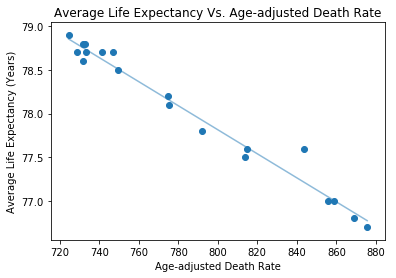

In [5]:
xs = recent['Age-adjusted Death Rate']
ys = recent['Average Life Expectancy (Years)']

res = linregress(xs, ys)

fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-', alpha=0.5)


plt.scatter(recent['Age-adjusted Death Rate'], recent['Average Life Expectancy (Years)']);
plt.xlabel('Age-adjusted Death Rate')
plt.ylabel('Average Life Expectancy (Years)')
plt.title('Average Life Expectancy Vs. Age-adjusted Death Rate')

print('R^2 =',res.rvalue**2)

It's important to distinguish the Age-Adjusted Death Rate from the Crude Death Rate. As shown in the graph below, the CDRs in the CDC mortality data differ much from the AADRs provided in the NCHS dataset. 

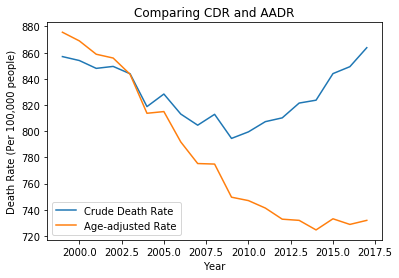

In [6]:
plt.plot(mortality_totals.Year, mortality_totals['Crude Rate'].astype('float64'), label='Crude Death Rate')
plt.plot(recent.Year, recent['Age-adjusted Death Rate'], label='Age-adjusted Rate');

plt.xlabel('Year')
plt.ylabel('Death Rate (Per 100,000 people)')
plt.title('Comparing CDR and AADR')
plt.legend();

Since we have the data for the total population and number of deaths for each year in the `mortality` and `mortality_totals` DataFrames, and the information for opioid-related deaths in the `opioid` and `opioid_totals` DataFrames, I can create two new DataFrames from which I will be able to calculate the theoretical AADR for the Zero-Opioid Scenario.

However, first I need to calculate the AADR for the mortality data I have to ensure it is as valid as the NCHS's AADRs to create a function for finding the ALE.

### Age-adjusted Death Rate Calculation

To calculate the AADRs with our data, we need to identify a "Standard Population" with which to adjust the CDRs. Since the NCHS uses the year 2000 for the Standard Population for their AADRs, it's what I will be using.

Below is a function I will be using to find the Standard Proportion for a given age group. The Standard Proportion for an age group is the proportion of the population that were in that age group in the Standard Population's distribution. I will be using it to add a column for the Standard Proportion to the `mortality` DataFrame in order to use the column to later find the Age-Adjusted Death Rates.

In [7]:
def age_group_pop_prop(row, year, df, df_totals):
    """    
    Takes in a row from a DataFrame, the desired year for the Standard Population,
    the DataFrame you would like to pull the total Standard Population from, and the 
    DataFrame that contains the Standard Population's proportions of deaths divided by 
    Ten-Year Age Groups Codes.
    
    Reads the Ten-Year Age Groups Code from the row, and returns the correct Standard Proportion.
    
    """  
    adjustment_mapping = {}
    standard_pop = float(df_totals[(df_totals.Year == year)].Population)

    for i, rows in df[df.Year == year].iterrows():
        adjustment_mapping[rows['Ten-Year Age Groups Code']] = float(rows['Population'])/standard_pop
    return adjustment_mapping.get(row['Ten-Year Age Groups Code'])

# Create Standard Proportion Column
mortality['Standard Proportion'] =  mortality.apply(lambda row: age_group_pop_prop(row, 2000, mortality, mortality_totals), axis=1)

I will be using the formula for Age-Adjusted Death Rate provided by the Missouri Department of Health and Senior Services (https://health.mo.gov/data/mica/CDP_MICA/AARate.html ), 

AADR = Summation of (ASDR X standard proportion) 
  
Where ASDR (Age-Specific Death Rate) = deaths in age group ÷ estimated population of that age group × 100,000, equivalent to the information held in the `Crude Rate` columns in the `mortality` DataFrame.

I will multiply the `Crude Rate` and the `Standard Proportion` columns in order to find the amount of each Crude Rate to sum for the year's Age-Adjusted Death Rate.

In [8]:
mortality['CR*SP'] =  mortality['Crude Rate'].astype('float64')*mortality['Standard Proportion']

I will now add sum the values for each year's Age-Adjusted Death Rate, and add it as a column to `mortality_totals`. 

In [9]:
def calculate_AADR(row, df):
    """
    Takes in an input row from a DataFrame of totals.
    Returns the Age-Adjusted Death Rate.
    """
    year = row.Year
    AADR = df[df.Year == year]['CR*SP'].sum()
    
    return AADR
    
# Create AADR Column      
mortality_totals['Age-adjusted Death Rate'] = mortality_totals.apply(lambda row: calculate_AADR(row, mortality), axis=1)    

My calculated Age Adjusted Death Rates closely match the trend of those in the NCHS dataset, but are offset by about 20 people per 100,000. Although I am unsure as to why the difference exists (I speculate it may be due to slight differences in the population estimates or calculation), since the trend of both lines is almost identical, so this shift in the intercept will not greatly affect the linear regression calculation.

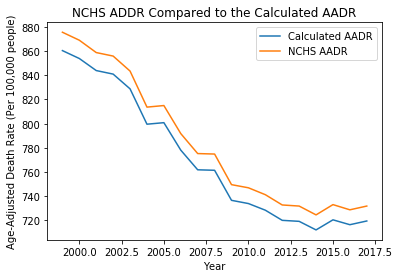

In [10]:
plt.plot(mortality_totals.Year, mortality_totals['Age-adjusted Death Rate'], label = 'Calculated AADR')
plt.plot(recent.Year, recent['Age-adjusted Death Rate'], label = 'NCHS AADR');

plt.xlabel('Year')
plt.ylabel('Age-Adjusted Death Rate (Per 100,000 people)');
plt.title('NCHS ADDR Compared to the Calculated AADR')
plt.legend();

I again performed a linear regression plotting ALE vs. AADR, this time using my AADR calculations to ensure they are as valid as the NCHS's AADRs to create a function that will estimate the Average Life Expectancy. 

The coefficient of determination is again .97. This validates that I can achieve a very close estimation of what the ALE would look like if I use a recalculated AADR.

R^2 = 0.9746100048542374


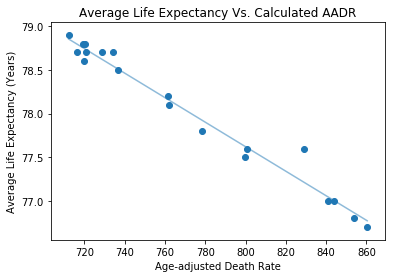

In [11]:
xs = mortality_totals['Age-adjusted Death Rate']
ys = recent['Average Life Expectancy (Years)']

res = linregress(xs, ys)

fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-', alpha=0.5)



plt.scatter(mortality_totals['Age-adjusted Death Rate'], recent['Average Life Expectancy (Years)']);
plt.xlabel('Age-adjusted Death Rate')
plt.ylabel('Average Life Expectancy (Years)')
plt.title('Average Life Expectancy Vs. Calculated AADR')
print('R^2 =',res.rvalue**2)

### Age-adjusted Death Rate Calculation for Zero-Opioid Scenario 

To find the AADRs for the Zero-Opioid Scenario, I will add back the deaths counted in the `opioid` DataFrame to the `mortality` deaths in a new DataFrame, and use same calculations as before. Then we will be able to convert this information into theoretical ALEs.

I will make a copy of `mortality` and `mortality_totals`, and alter them to not include the deaths related to opioid overdoses to create `mortality_zero_opioid` and `mortality_zero_opioid_totals`.

In [12]:
mortality_zero_opioid = mortality.copy().drop(['Standard Proportion','CR*SP'], axis=1)
mortality_zero_opioid_totals = mortality_totals.copy().drop(['Age-adjusted Death Rate'], axis=1)

#Remove the deaths related to opioid overdoses
mortality_zero_opioid.Deaths = mortality_zero_opioid.Deaths - opioid.Deaths
mortality_zero_opioid_totals.Deaths = mortality_zero_opioid_totals.Deaths - opioid_totals.Deaths


#Remove the deaths contributing to the crude rate
mortality_zero_opioid['Crude Rate'] = mortality_zero_opioid['Crude Rate'].astype('Float64')-opioid['Crude Rate'].astype('Float64')
mortality_zero_opioid_totals['Crude Rate'] = mortality_zero_opioid_totals['Crude Rate'].astype('Float64')-opioid_totals['Crude Rate'].astype('Float64')



We will perform the same process as before to find the new Age-adjusted Death Rates.

In [13]:
#Creating Standard Proportion Column and the (Crude Rate * Standard Prop) column
mortality_zero_opioid['Standard Proportion'] =  mortality_zero_opioid.apply(lambda row: age_group_pop_prop(row, 2000, mortality_zero_opioid, mortality_zero_opioid_totals), axis=1)
mortality_zero_opioid['CR*SP'] =  mortality_zero_opioid['Crude Rate'].astype('float64')*mortality_zero_opioid['Standard Proportion']

#Finding the AADRs for the adjusted dataset
mortality_zero_opioid_totals['Age-adjusted Death Rate'] = mortality_zero_opioid_totals.apply(lambda row: calculate_AADR(row, mortality_zero_opioid), axis=1)    

### Average Life Expectancy Calculations and Validation

I will now transfer this information into terms of life expectancies. I will use the linear regression model I created to fit the data to estimate life expectancy using the true calculated AADRs and the Zero-Opioid Scenario AADRs.

In [14]:
life_expect = recent[['Year','Average Life Expectancy (Years)']].join(mortality_totals['Age-adjusted Death Rate']).join(mortality_zero_opioid_totals['Age-adjusted Death Rate'], rsuffix=' -Opioid')

#Column with the model life expectancy
life_expect['ALE Expected by AADR'] = life_expect['Age-adjusted Death Rate']*res.slope + res.intercept

#Column with the difference between the true ALE and my calculated ALE
life_expect['Residuals'] = life_expect['Average Life Expectancy (Years)'] - life_expect['ALE Expected by AADR']

#Column with the life expectancy we would expect to see if there were no opioid-related deaths
life_expect['ALE Expected by Zero-Opioid AADR'] = life_expect['Age-adjusted Death Rate -Opioid']*res.slope + res.intercept

#Column with the theoretical loss in ALE from theoretical zero-opioid scenario
life_expect['Theoretical Loss in ALE'] = life_expect['Average Life Expectancy (Years)'] - life_expect['ALE Expected by Zero-Opioid AADR']

Graphed below are both the ALEs reported by the NCHS and the ones calculated using my regression model. This graph is another validation of my model, as it traces the true ALE very closely.

Excluding the year 2003, my function for finding the Average Life Expectancy from the AADR produces a result accurate to within .15 years of the true ALE, so it is a decently good estimator of the life expectancy we would expect to see if there were no contributing opioid-related deaths. 

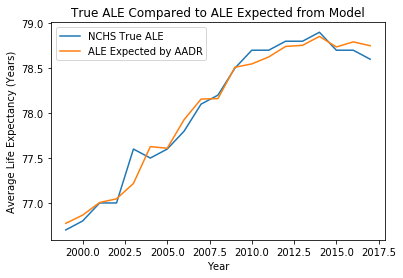

In [15]:
plt.plot(life_expect.Year, life_expect['Average Life Expectancy (Years)'], label='NCHS True ALE')
plt.plot(life_expect.Year, life_expect['ALE Expected by AADR'], label='ALE Expected by AADR')

plt.xlabel('Year')
plt.ylabel('Average Life Expectancy (Years)')
plt.title('True ALE Compared to ALE Expected from Model')
plt.legend();

## **Results**

Below is the same graph produced above, overlaid with the Zero-Opioid Scenario ALE. In the earlier years, the ALE for a Zero-Opioid Scenario differs very little from the actual ALE. However, in the most recent years, the gap between the two is wider than it has ever been. 

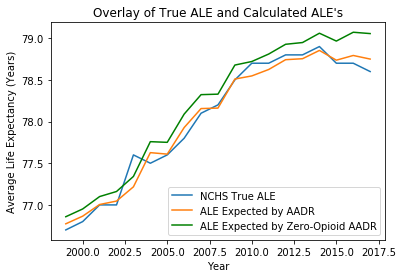

In [16]:
plt.plot(life_expect.Year, life_expect['Average Life Expectancy (Years)'], label='NCHS True ALE')
plt.plot(life_expect.Year, life_expect['ALE Expected by AADR'], label='ALE Expected by AADR')
plt.plot(life_expect.Year, life_expect['ALE Expected by Zero-Opioid AADR'], label='ALE Expected by Zero-Opioid AADR', color='green')

plt.xlabel('Year')
plt.ylabel('Average Life Expectancy (Years)')
plt.title('Overlay of True ALE and Calculated ALE\'s')
plt.legend();

In the graph, we can see in the year 2003 the ALE we would expect to see if there had been no opioid-related deaths according to our model is lower than the actual ALE, which is a senseless result. The linear regression that created the model had an outlier in the year 2003, so it explains why our model does not work well in this result.

## **Conclusion**

So, _**what is the effect of the increased opioid-related deaths on the Average Life Expectancy in the US?**_

According to the model, I would expect that the ALE in 2017 would have been about .46 years higher if there had been no opioid-related deaths (79.06 years, compared to the observed 78.6 years). Similarly, in 2016 the ALE would have been .37 years higher in a Zero-Opioid Scenario (79.07 years compared to the observed 78.7).

It is only recently that these deaths have created an observable effect this large. In 1999, the difference between the Zero-Opioid ALE and the observed ALE was .16 years (76.86 years compared to the actual 76.7).

The Average Life Expectancy is a very robust summary statistic that takes information about the overall health of a country to produce one number. The increased number of opioid overdoses taking lives prematurely has more than ever negatively impacted the years of life a newborn would be expected to live.
